In [120]:
from datetime import datetime
from nltk.tokenize import TweetTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
from astropy.table import Table
from astropy.time import Time
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('apw-notebook')
%matplotlib inline

from scipy.stats import binned_statistic

import calendar
month_map = dict((v,k) for k,v in enumerate(calendar.month_abbr))

In [2]:
df = pd.read_csv('../data/astropy_commits.csv')

In [5]:
df['name'].value_counts()[:16]

Erik Tollerud          2393
Thomas Robitaille      2200
Tom Aldcroft           1517
Michael Droettboom     1509
Marten van Kerkwijk     819
Adrian Price-Whelan     623
Brigitta Sipocz         431
Larry Bradley           413
Pey Lian Lim            314
Michael Mueller         298
Nadia Dencheva          287
Matthew Craig           240
Simon Conseil           221
Erik Bray               190
Michael Seifert         186
Axel Donath             152
Name: name, dtype: int64

In [121]:
sid = SentimentIntensityAnalyzer()
tkn = TweetTokenizer()

In [135]:
polarities = []
for index, row in rows.iterrows():
    msg = str(row['message'])
    sentence = " ".join(tkn.tokenize(msg))
    
    ss = sid.polarity_scores(msg)
    
    # parse date
    month_name, day, hms, year, *_ = row['date'].split()
    hms = list(map(int, hms.split(':')))
    ss['hour'] = np.sum(np.array([1., 1/60., 1/3600]) * np.array(hms))
    ss['time'] = Time(datetime(int(year), month_map[month_name], int(day), hms[0], hms[1], hms[2]))
    polarities.append(ss)
    
all_polarities = Table(polarities)
all_polarities['time'] = Time(all_polarities['time'])

In [164]:
def make_plots(idx=None, title="", statistic='mean'):
    if idx is not None:
        polarities = all_polarities[idx]
    else:
        polarities = all_polarities
        
    pos_color = '#2b8cbe'
    neg_color = '#de2d26'
    figsize = (12, 5)
    
    # --------------------------------------
    # binned by hour of the day (local time)
    bins = np.arange(0, 24+1, 1)
    bin_ctr = (bins[:-1] + bins[1:]) / 2.

    pos_res = binned_statistic(polarities['hour'], polarities['pos'], 
                               bins=bins, statistic=statistic)
    neg_res = binned_statistic(polarities['hour'], polarities['neg'], 
                               bins=bins, statistic=statistic)
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    ax.plot(bin_ctr, pos_res.statistic, label='positive',
             marker='None', drawstyle='steps-mid', color=pos_color)
    ax.plot(bin_ctr, neg_res.statistic, label='negative',
             marker='None', drawstyle='steps-mid', color=neg_color)
    ax.legend(loc='best', fontsize=18)

    ax.set_xlabel('time [hour]')
    ax.set_xlim(6, 20)
    ax.set_title(title)
    
    # -----------------------------
    # binned by absolute time
    month_bins = np.arange(polarities['time'].mjd.min(), polarities['time'].mjd.max()+1, 30)
    month_bin_ctr = (month_bins[:-1] + month_bins[1:]) / 2.

    month_pos_res = binned_statistic(polarities['time'].mjd, polarities['pos'], 
                                     bins=month_bins, statistic=statistic)
    month_neg_res = binned_statistic(polarities['time'].mjd, polarities['neg'], 
                                     bins=month_bins, statistic=statistic)
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    ax.plot(month_bin_ctr, month_pos_res.statistic, label='positive',
             marker='None', drawstyle='steps-mid', color=pos_color)
    ax.plot(month_bin_ctr, month_neg_res.statistic, label='negative',
             marker='None', drawstyle='steps-mid', color=neg_color)

    ax.set_title(title)
    ax.set_xlabel('MJD')
    ax.legend(loc='best', fontsize=18)

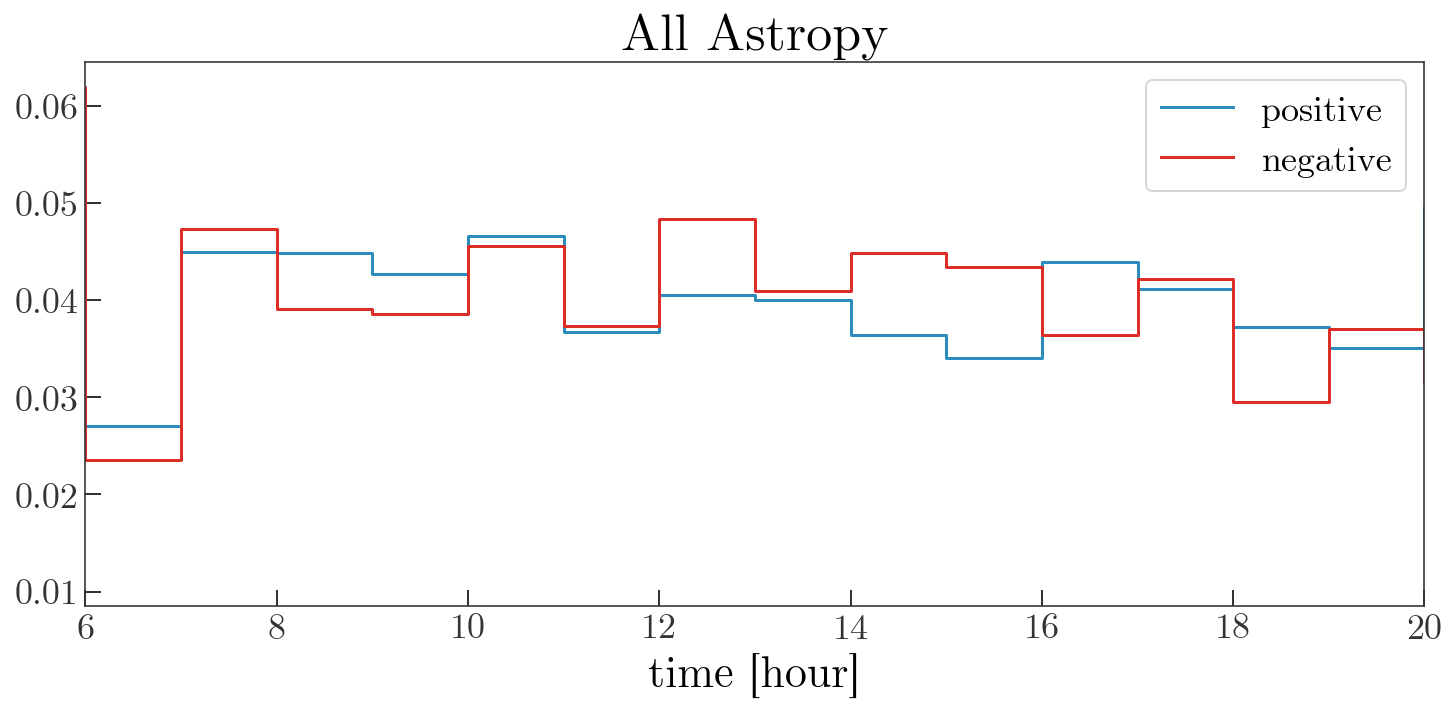

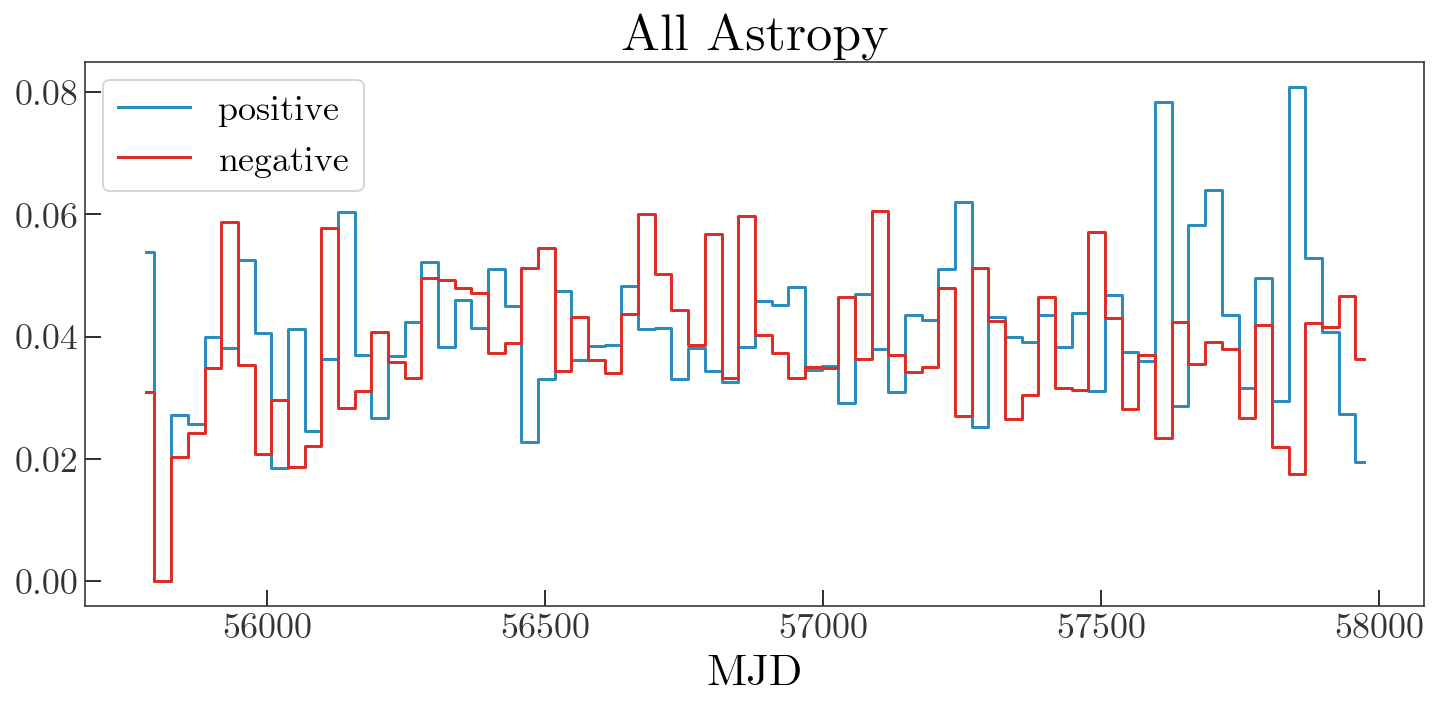

In [165]:
make_plots(title='All Astropy')

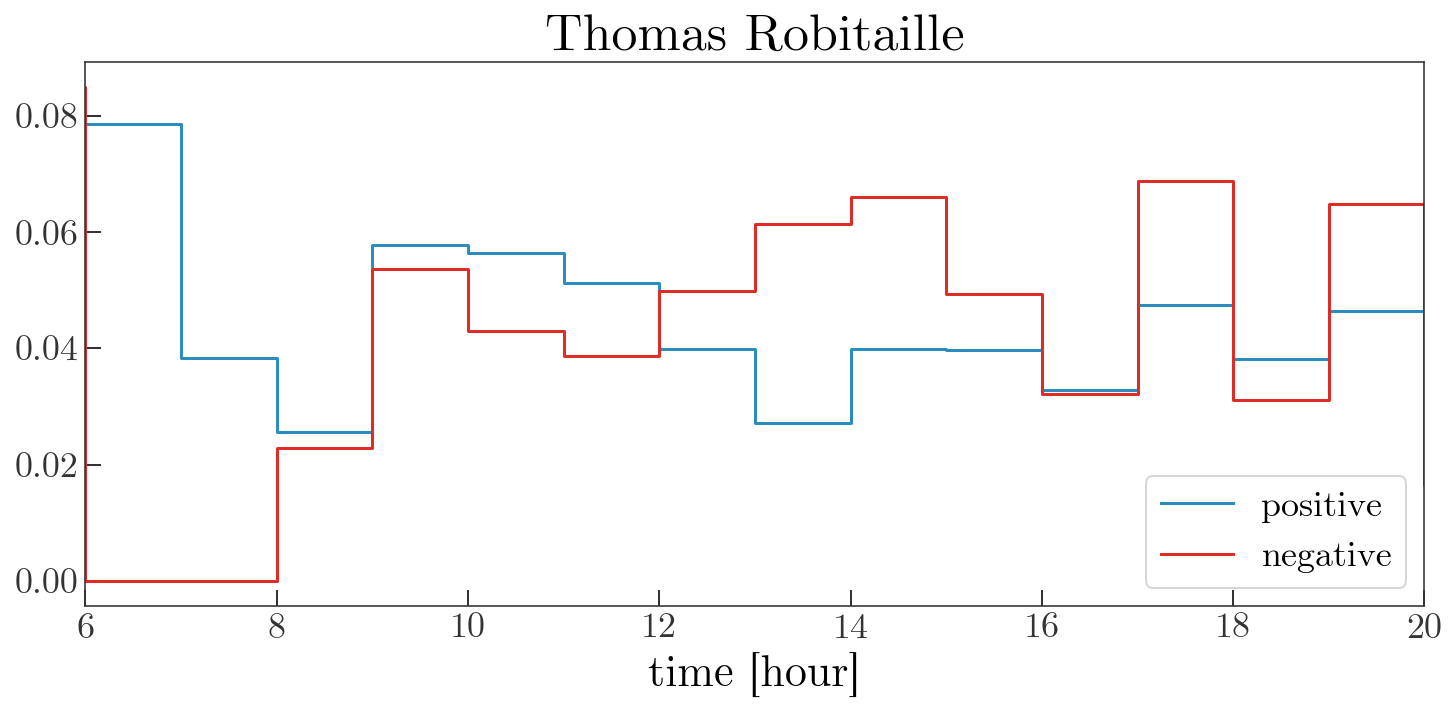

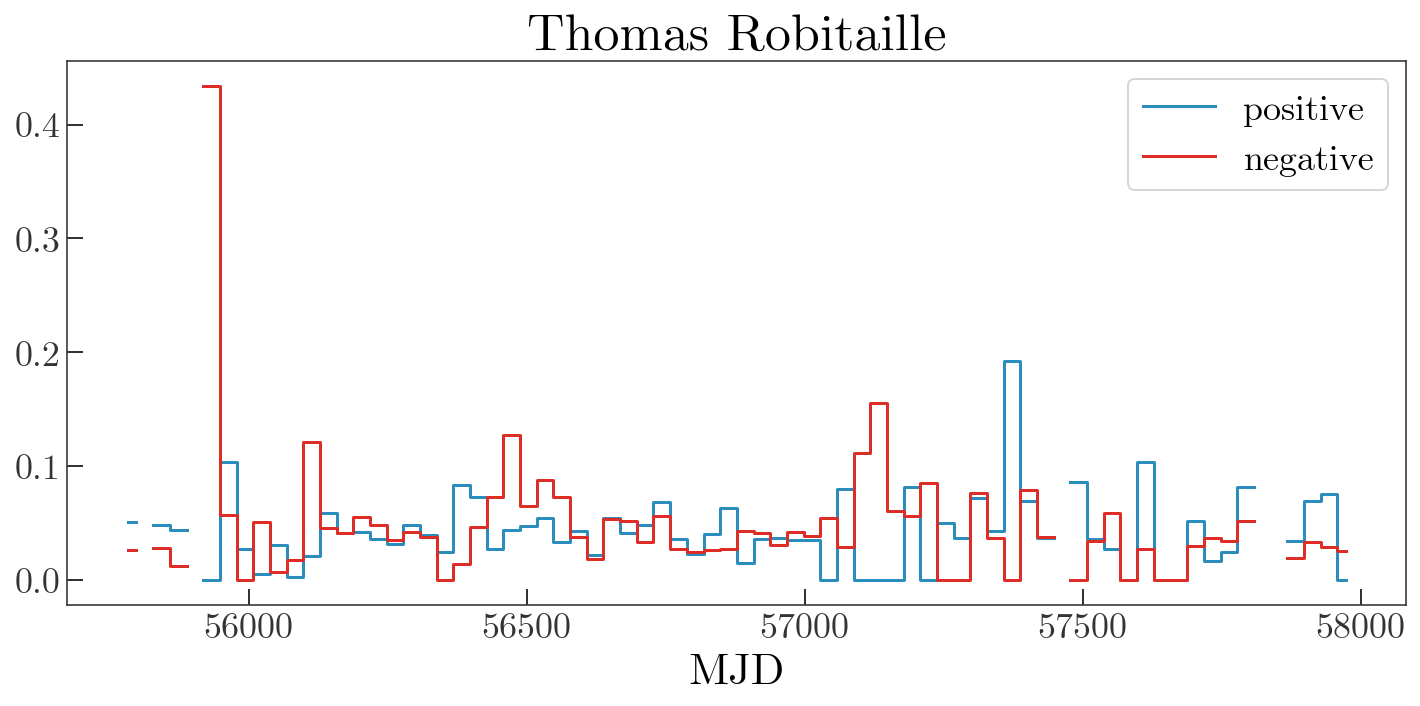

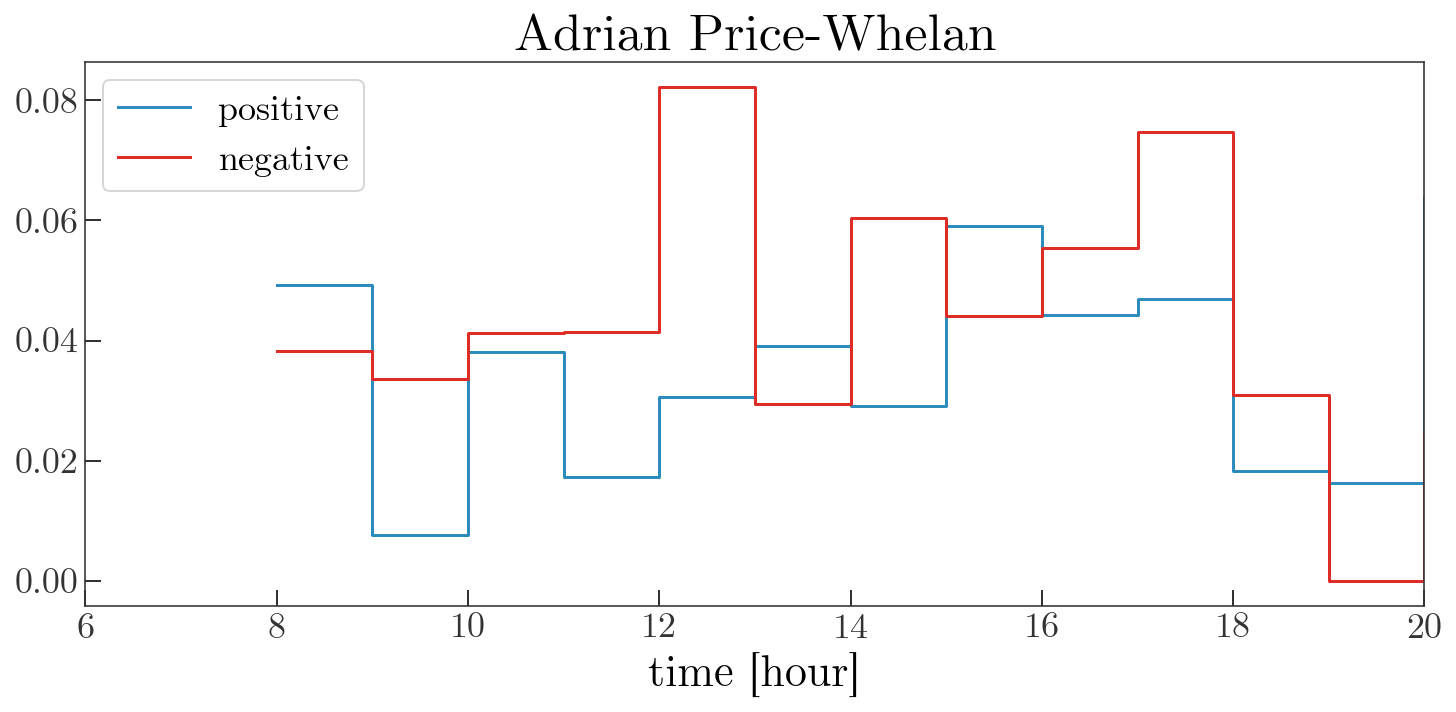

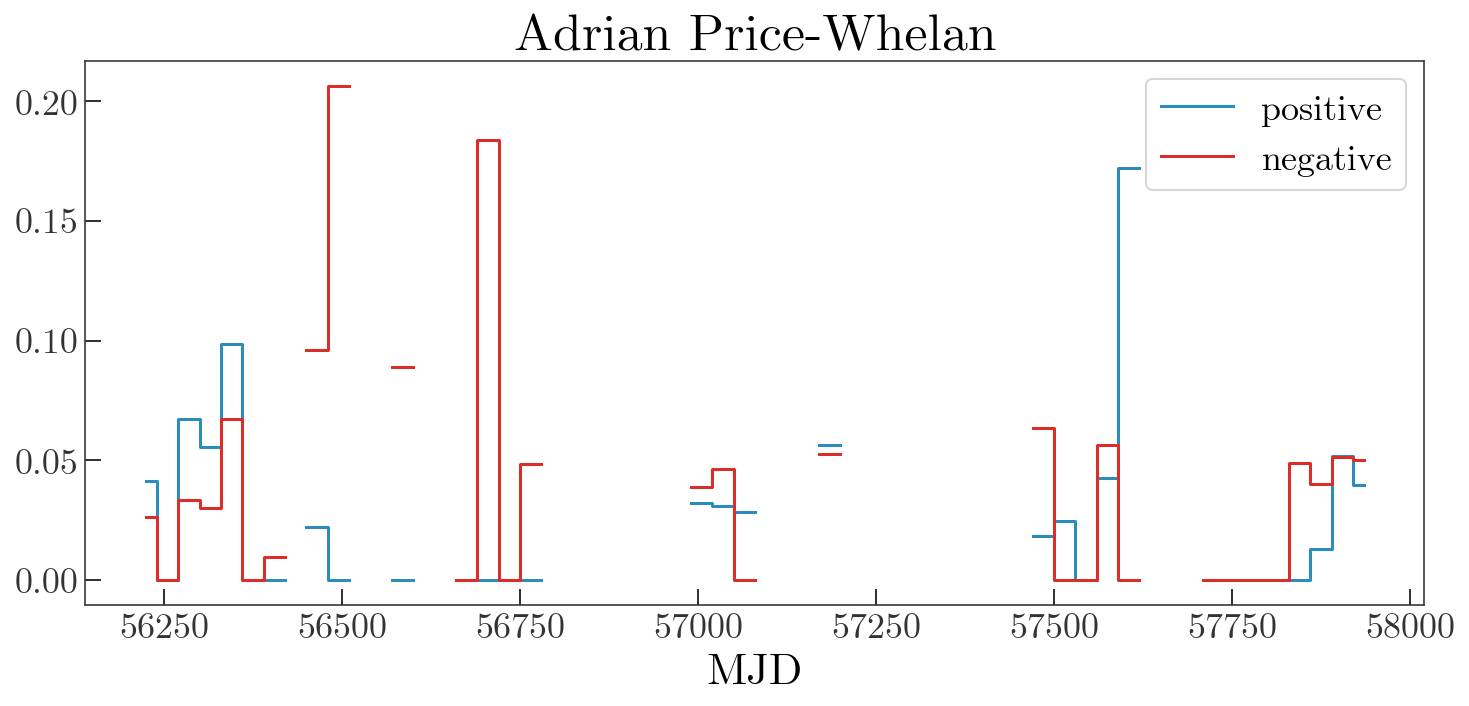

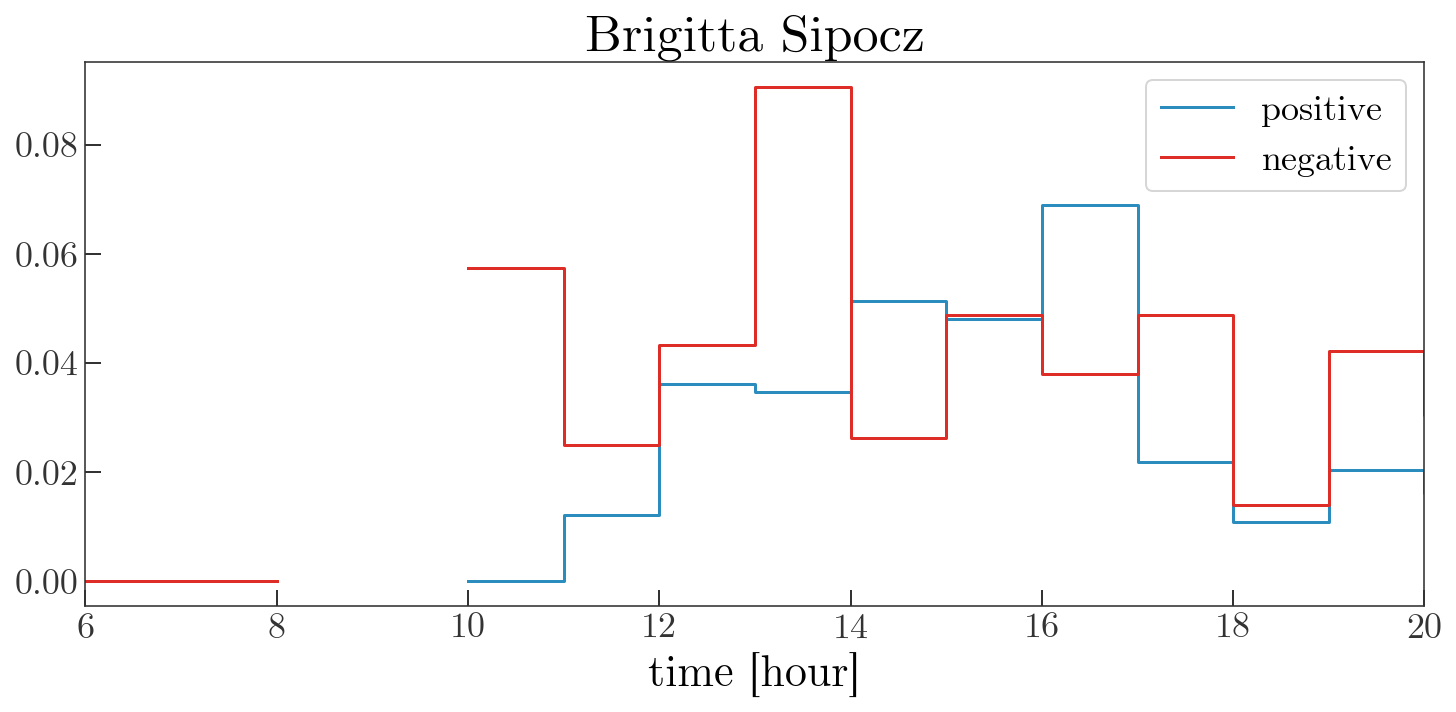

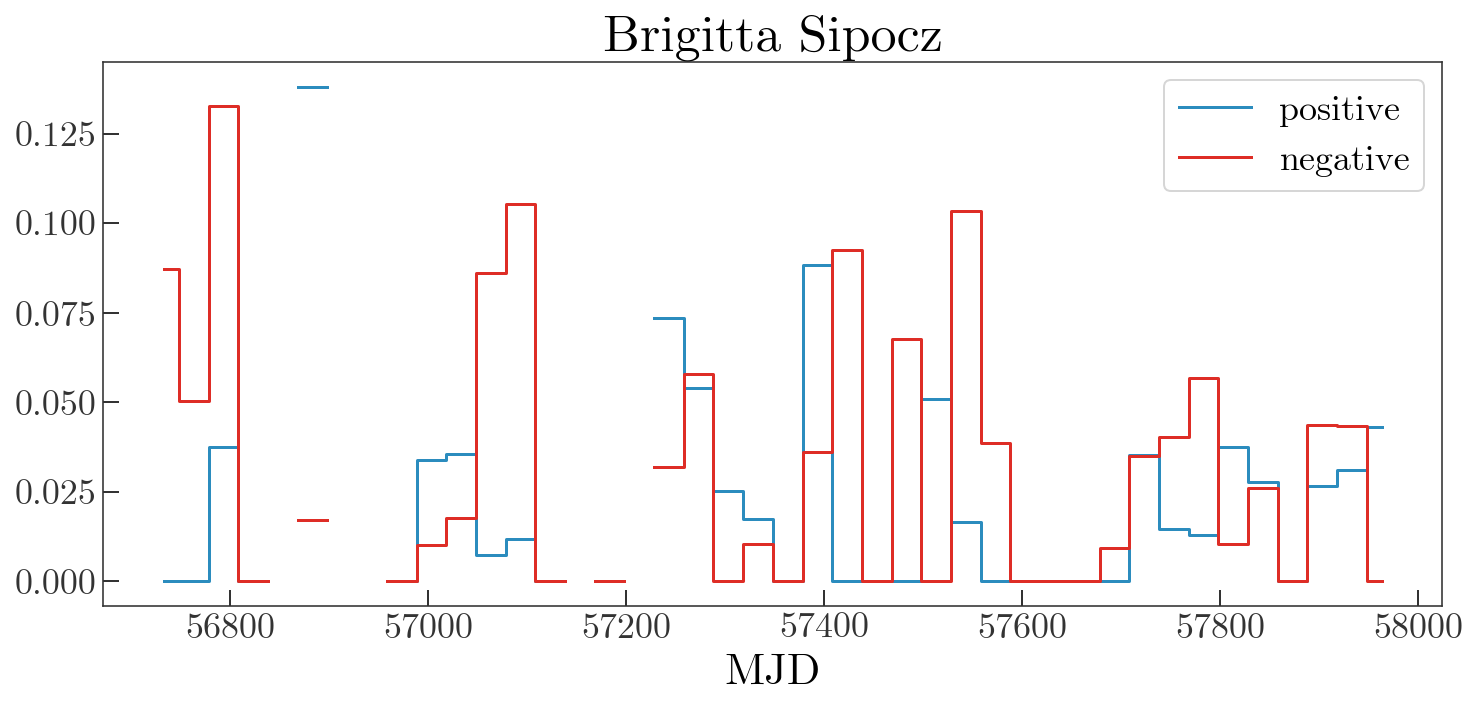

In [166]:
for name in ['Thomas Robitaille', 'Adrian Price-Whelan', 'Brigitta Sipocz']:
    make_plots(idx=np.array(df['name'] == name), title=name)

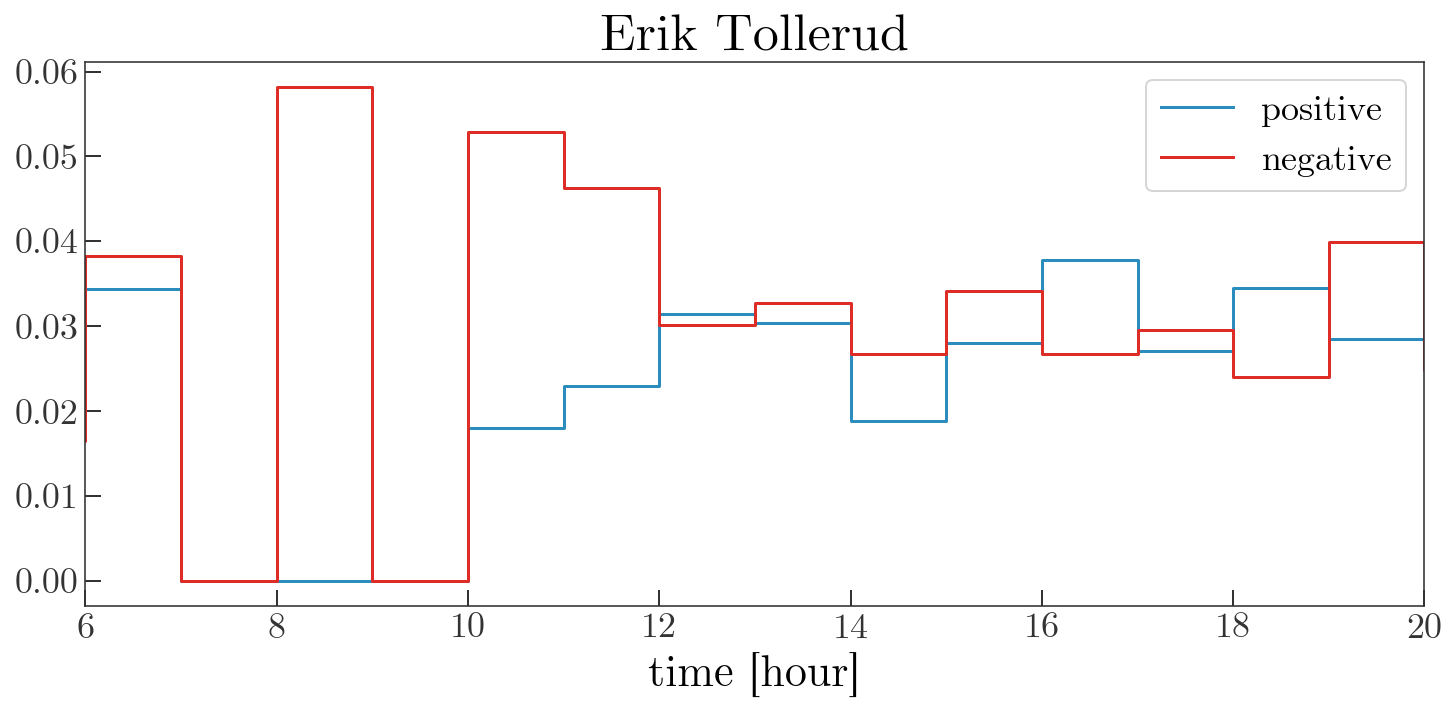

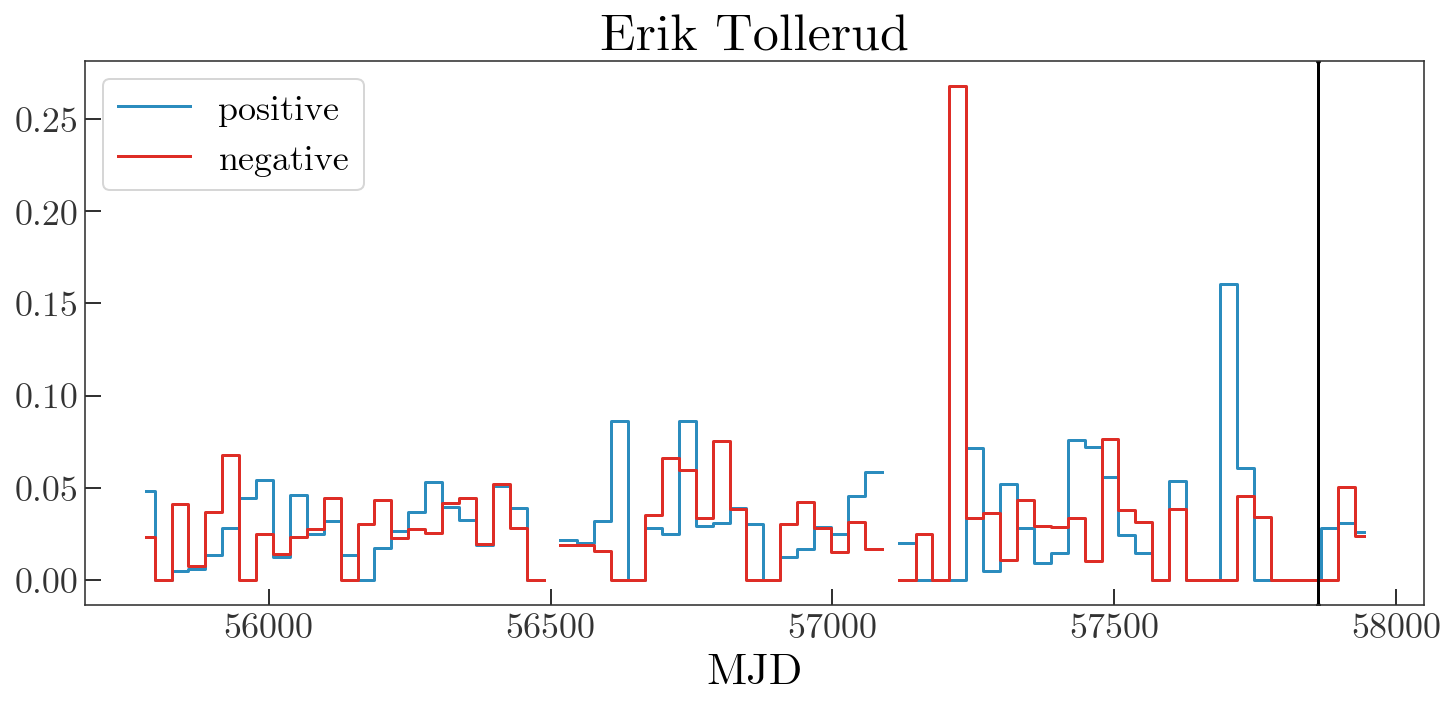

In [172]:
name = 'Erik Tollerud'
make_plots(idx=np.array(df['name'] == name), title=name)
plt.axvline(Time(datetime(2017, 4, 18)).mjd)